In [1]:
import cv2
import os
VERSION = 11
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.insert(0, str(Path(os.path.abspath('')).parent))
import math
import torch
import matplotlib.pyplot as plt
import mediapy
from icecream import ic
from data import loader
import random
import time
from tqdm import tqdm
import numpy as np
from utils import cam_util
from utils.train_util import *
# from models.vertex_color import Model, TetOptimizer
from models.ingp_density import Model, TetOptimizer
from fused_ssim import fused_ssim
from pathlib import Path, PosixPath
from utils.args import Args
import pickle
import json
from utils import safe_math
from delaunay_rasterization.internal.render_err import render_err
import imageio
from torch.profiler import profile, ProfilerActivity, record_function
from utils import test_util
from utils.graphics_utils import tetra_volume
import termplotlib as tpl
from delaunay_rasterization.internal.alphablend_tiled_slang import render_alpha_blend_tiles_slang_raw
torch.set_num_threads(1)


cmap = plt.get_cmap("jet")

eps = torch.finfo(torch.float).eps
args = Args()
args.tile_size = 16
args.output_path = Path("output")
args.iterations = 10000
args.sh_interval = 0
args.image_folder = "images_4"
args.eval = True
args.dataset_path = Path("/data/nerf_datasets/360/kitchen")
args.output_path = Path("output/test/")
args.delaunay_start = 100000

args.log2_hashmap_size = 22
args.per_level_scale = 2
args.L = 10
args.density_offset = -2
args.light_offset = -3
args.lights_lr = 0.0025
args.final_lights_lr = 0.0025
args.color_lr = 0.005
args.final_color_lr = 0.005
args.p_norm = 100
args.freeze_start = 9000

args.hidden_dim = 64
args.scale_multi = 1.0

args.lr_delay = 0
args.vertices_lr = 5e-4
args.final_vertices_lr = 1e-5
args.max_steps = 10000
args.num_lights = 2
args.sh_lr_delay = 1000

args.vertices_lr_delay_multi = 1e-8
args.encoding_lr = 5e-4
args.final_encoding_lr = 5e-4

args.network_lr = 5e-5
args.final_network_lr = 5e-5

args.lambda_ssim = 0.1
args.clone_lambda_ssim = 0.1

args.weight_decay = 0.01
args.vertices_beta = [0.9, 0.99]
args.contract_vertices = False
args.hashmap_dim = 4

args.lambda_dist = 1e-7
args.ladder_p = -0.25
args.pre_multi = 10000

args.split_std = 0.1
args.split_mode = "barycentric"
args.clone_schedule = "quadratic"
args.base_min_t = 0.3
args.sample_cam = 3

args.output_path.mkdir(exist_ok=True, parents=True)

train_cameras, test_cameras, scene_info = loader.load_dataset(
    args.dataset_path, args.image_folder, data_device="cuda", eval=args.eval)


device = torch.device('cuda')
model = Model.init_from_pcd(scene_info.point_cloud, train_cameras, device,
                            max_lights = args.num_lights if args.sh_interval <= 0 else 0,
                            **args.as_dict())
min_t = model.scene_scaling * args.base_min_t

tet_optim = TetOptimizer(model, **args.as_dict())


/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for co

KeyboardInterrupt: 

In [ ]:
inds = []
iteration = 0

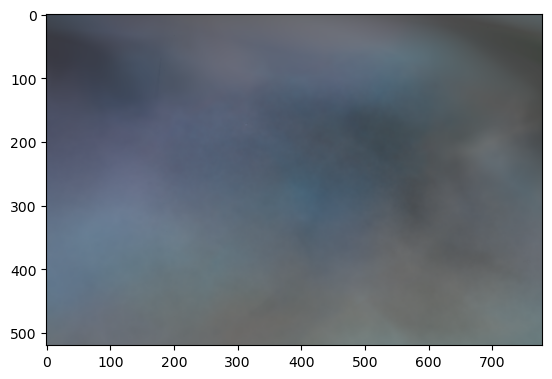

In [ ]:
sample_camera = test_cameras[33]
with torch.no_grad():
    render_pkg = render(sample_camera, model, min_t=min_t, tile_size=args.tile_size)
    sample_image = render_pkg['render']
    sample_image = sample_image.permute(1, 2, 0)
    sample_image = (sample_image.detach().cpu().numpy()*255).clip(min=0, max=255).astype(np.uint8)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR)
    plt.imshow(sample_image)
    plt.show()


In [2]:
for i in range(100):
    if len(inds) == 0:
        inds = list(range(len(train_cameras)))
    ind = inds.pop()
    camera = train_cameras[ind]
    target = camera.original_image.cuda()

    st = time.time()
    bg = 0
    render_pkg = render(camera, model, bg=bg, min_t=min_t, **args.as_dict())
    image = render_pkg['render'].clip(min=0, max=1)
    l2_loss = ((target - image)**2).mean()
    reg = tet_optim.regularizer()
    ssim_loss = 1-fused_ssim(image.unsqueeze(0), target.unsqueeze(0))
    loss = (1-args.lambda_ssim)*l2_loss + args.lambda_ssim*ssim_loss + reg + args.lambda_dist * render_pkg['distortion_loss']

    loss.backward()

    tet_optim.main_step()
    tet_optim.main_zero_grad()

    tet_optim.vertex_optim.step()
    tet_optim.vertex_optim.zero_grad()

    st = time.time()
    model.update_triangulation()

    tet_optim.update_learning_rate(iteration)

    with torch.no_grad():
        render_pkg = render(sample_camera, model, min_t=min_t, tile_size=args.tile_size)
        sample_image = render_pkg['render']
        sample_image = sample_image.permute(1, 2, 0)
        sample_image = (sample_image.detach().cpu().numpy()*255).clip(min=0, max=255).astype(np.uint8)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR)
        plt.imshow(sample_image)
        plt.show()
    iteration += 1

NameError: name 'inds' is not defined